In [8]:
import pandas as pd
import numpy as np
from scipy.stats import beta
import random
import seaborn as sns
import matplotlib.pyplot as plt

# set the number of trials
N = 100000
# set the number of bandits
N_bandits = 5

In [9]:
class BayesianAB:
  def __init__(
      self,
      number_of_bandits: int = 2,
  ):
    self.prob_true= [0] * number_of_bandits # only in exercise
    self.prob_win = [0] * number_of_bandits
    self.history = [] # only in exercise
    self.count = [0] * number_of_bandits # only in exercise
    # a and b are for bayesian_bandits only
    self.a = [1] * number_of_bandits
    self.b = [1] * number_of_bandits

    # set the largest bandit to have a win rate of 0.75 and rest lower
    self.prob_true[-1] = 0.75
    for i in range(0, number_of_bandits-1):
      self.prob_true[i] = round(0.75 - random.uniform(0.05, 0.65), 2)


  def pull(
      self,
      i,
  ) -> bool:
    return random.random() < self.prob_true[i]

  def update(
      self,
      i,
      k,
  ):
    outcome = self.pull(i)
    # may use a constant discount rate to discount past
    self.prob_win[i] = (self.prob_win[i] * k + outcome) / (k+1)
    self.history.append(self.prob_win.copy())
    self.count[i] += 1

  ####################
  # epsilon greedy
  def epsilon_greedy(
      self,
      epsilon: float, # decay epsilon?
  ) -> list:

    self.history.append(self.prob_win.copy())

    for k in range(1, N):
      # find index of the largest value in prob_win
      i = np.argmax(self.prob_win)

      if random.random() < epsilon:
        j = random.randrange(0, len(self.prob_win))
        while j == i:
          j = random.randrange(0, len(self.prob_win))
        else:
          i = j

      self.update(i, k)

    return self.history
  
  ####################
  # optimistic initial values
  def optim_init_val(
      self,
      init_val: float,
  ) -> list:

    self.prob_win = [init_val] * len(self.prob_win)
    self.history.append(self.prob_win.copy())

    for k in range(1, N):
      # find index of the largest value in prob_win
      i = np.argmax(self.prob_win)

      self.update(i, k)

    return self.history

  ####################
  # upper confidence bound (UCB1)
  def ucb1(
      self,
  ) -> list:

    self.history.append(self.prob_win.copy())
    bandit_count = [0.0001] * len(self.prob_win)
    # bound = [0] * len(self.prob_win)

    for k in range(1, N):
      bound = self.prob_win + np.sqrt(2 * np.log(k) / bandit_count)
      # find index of the largest value in bound
      i = np.argmax(bound)

      self.update(i, k)
      bandit_count[i] += 1

    return self.history
    
  # bayesian_bandits sample
  def bb_sample(
      self,
      a: int, # alpha
      b: int, # beta
      size: int = 10,
  ) -> list:

    return np.random.beta(a, b, size)
  
  # bayesian_bandits update
  def bb_update(
      self,
      a: list,
      b: list,
      i,
  ):

    outcome = self.pull(i)
    # may use a constant discount rate to discount past
    a[i] += outcome
    b[i] += 1 - outcome
    self.count[i] += 1
  
    return a, b
  
  ####################
  # Bayesian Bandits
  # For Bernoulli distribution, the conjugate prior is Beta distribution
  def bayesian_bandits(
      self,
  ) -> list:

    a_hist, b_hist = [], []
    a_hist.append(self.a.copy())
    b_hist.append(self.b.copy())

    for k in range(1, N):
      sample_max = []

      for m in range(len(self.prob_true)):
        m_max = np.max(self.bb_sample(self.a[m], self.b[m]))
        sample_max.append(m_max.copy())
      
      i = np.argmax(sample_max)

      self.a, self.b = self.bb_update(self.a, self.b, i)
      a_hist.append(self.a.copy())
      b_hist.append(self.b.copy())
      
    self.history = [a_hist, b_hist]
    return self.history


In [10]:
# define functions to plot history

def plot_history(
    history: list,
    prob_true: list,
):

  df_history = pd.DataFrame(history)
  plt.figure(figsize=(20,5))

  for i in range(len(prob_true)):
    sns.lineplot(x=df_history.index, y=df_history[i])
  plt.legend(prob_true)


def bb_plot_history(
    history: list,
    prob_true: list,
    k = -1,
):

    x = np.linspace(0, 1, 100)
    legend_str = [[]] * len(prob_true)
    plt.figure(figsize=(20,5))
    
    for i in range(len(prob_true)):
      a = history[0][k][i]
      b = history[1][k][i]
      y = beta.pdf(x, a, b)
      legend_str[i] = f'{prob_true[i]}, alpha: {a}, beta: {b}'
      plt.plot(x, y)

    plt.legend(legend_str)

The true win rates: [0.24, 0.62, 0.66, 0.3, 0.75]
The observed win rates: [0.25       0.61445783 0.65172414 0.33333333 0.75051756]
Number of times each bandit was played: [16, 166, 290, 21, 99506]


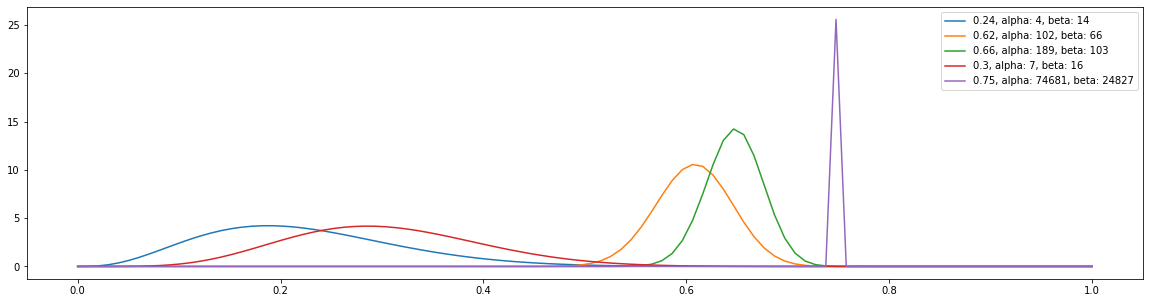

In [11]:
# bayesian bandits
# When rewards are real values following a Gaussian?
# See "55. Thompson Sampling With Gaussian Reward Cod"
bb = BayesianAB(N_bandits)
print(f'The true win rates: {bb.prob_true}')
bb_history = bb.bayesian_bandits()
print(f'The observed win rates: {np.divide(bb.history[0][-1], bb.count)}')
print(f'Number of times each bandit was played: {bb.count}')

bb_plot_history(bb.history, bb.prob_true)

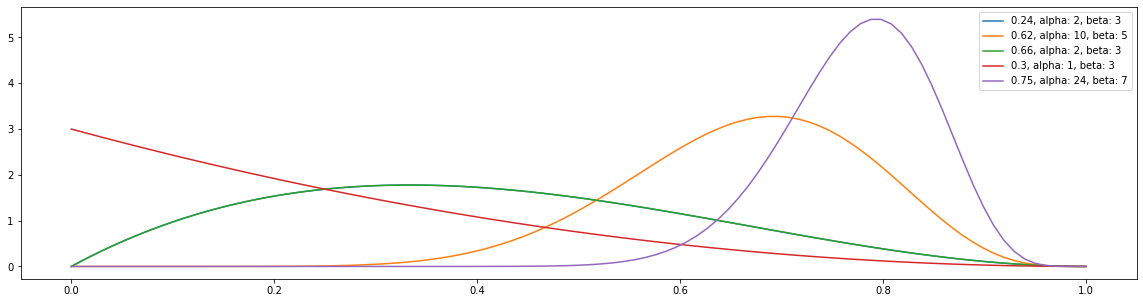

In [12]:
# after 50 pulls
bb_plot_history(bb.history, bb.prob_true, 50)

The true win rates: [0.26, 0.64, 0.47, 0.39, 0.75]
The observed win rates: [0.09642598730288125, 0.1742263093356456, 0.467683223357415, 0.18113774630230717, 0.30402940285113045]
Number of times each bandit was played: [4949, 4869, 80089, 5098, 4994]


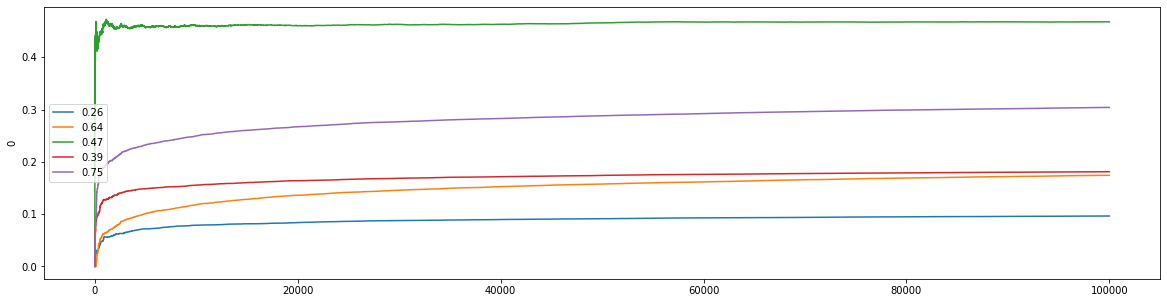

In [13]:
# epsilon greedy
# When rewards are real values following a Gaussian?
# See "44. Comparing Different Epsilons"
eg = BayesianAB(N_bandits)
print(f'The true win rates: {eg.prob_true}')
eg_history = eg.epsilon_greedy(0.2)
print(f'The observed win rates: {eg.prob_win}')
print(f'Number of times each bandit was played: {eg.count}')
# add total rewards?
# add overall win rate?

plot_history(history=eg.history, prob_true=eg.prob_true)

The true win rates: [0.7, 0.15, 0.11, 0.66, 0.75]
The observed win rates: [0.6633333333333333, 0.732502035162507, 0.7323497623237367, 0.7324413994786658, 0.7489767162189837]
Number of times each bandit was played: [2, 52, 61, 271, 99613]


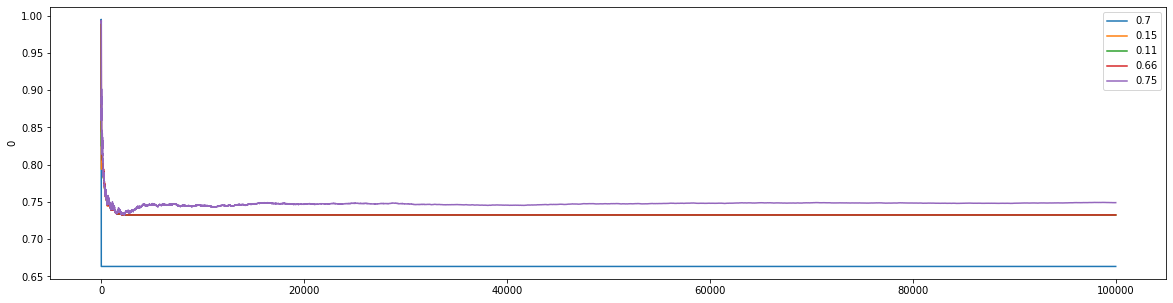

In [14]:
# optimistic initial values
oiv = BayesianAB(N_bandits)
print(f'The true win rates: {oiv.prob_true}')
oiv_history = oiv.optim_init_val(0.99)
print(f'The observed win rates: {oiv.prob_win}')
print(f'Number of times each bandit was played: {oiv.count}')

plot_history(history=oiv.history, prob_true=oiv.prob_true)

The true win rates: [0.68, 0.51, 0.68, 0.12, 0.75]
The observed win rates: [0.6789640129622264, 0.3754582256679832, 0.20353579528351418, 0.00011405527202796502, 0.27151456903221843]
Number of times each bandit was played: [99499, 227, 96, 48, 129]


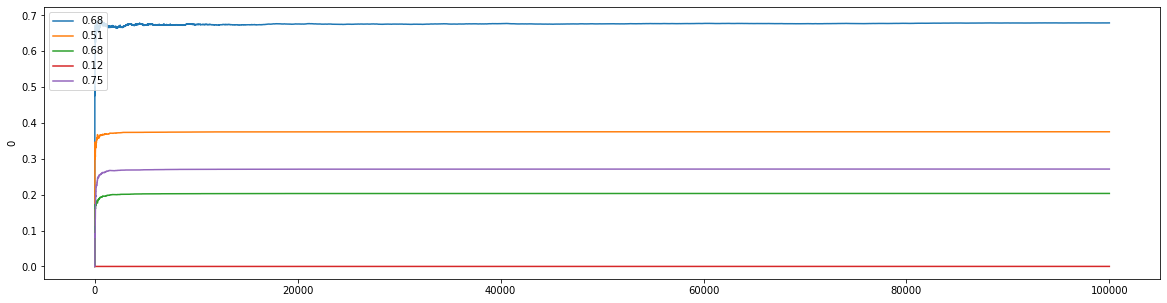

In [15]:
# UCB1
ucb = BayesianAB(N_bandits)
print(f'The true win rates: {ucb.prob_true}')
ucb_history = ucb.ucb1()
print(f'The observed win rates: {ucb.prob_win}')
print(f'Number of times each bandit was played: {ucb.count}')

plot_history(history=ucb.history, prob_true=ucb.prob_true)

In [ ]:
# Final comment: From the examples above, it looks like UCB1 and Epsilon Greedy are not robust in picking the "best" bandit